# Identificando Fraudes de Cartão de Crédito (Classificação)

Esse projeto tem como objetivos:
- Analisar um arquivo CSV com 1 milhão de transações de cartão de crédito (normais e fraudulentas) para identificar as **características comuns nas fraudes**;
- Treinar um **modelo de machine learning** para ser capaz de classificar futuras transações como fraudulentas ou não através de suas características.

# Instalando as bibliotecas

In [347]:
# !pip install --upgrade scikit-learn imbalanced-learn
# !pip install graphviz

# Importando os dados

In [349]:
import pandas as pd
pd.options.display.float_format = "{:,}".format

uri = "https://github.com/marcosf520/data-science-machine-learning/raw/refs/heads/master/classificacao-fraudes/dados/fraud_dataset.csv"
dados = pd.read_csv(uri)
dados

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.87785658389723,0.3111400080477545,1.9459399775518595,1.0,1.0,0.0,0.0,0.0
1,10.829942699255543,0.1755915022816658,1.294218810619857,1.0,0.0,0.0,0.0,0.0
2,5.091079490616996,0.8051525945853258,0.4277145611942758,1.0,0.0,0.0,1.0,0.0
3,2.2475643282963613,5.60004354707232,0.3626625780570958,1.0,1.0,0.0,1.0,0.0
4,44.19093600261837,0.5664862680583477,2.2227672978404707,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
999995,2.2071007085956595,0.1126513027947371,1.6267975897996456,1.0,1.0,0.0,0.0,0.0
999996,19.872725762075127,2.6839037264517254,2.778302935930713,1.0,1.0,0.0,0.0,0.0
999997,2.914856986796768,1.4726866870566833,0.2180754860145264,1.0,1.0,0.0,1.0,0.0
999998,4.258729391720518,0.2420233659455144,0.4758220644483312,1.0,0.0,0.0,1.0,0.0


## Significado das colunas

- **distance_from_home**: distância do local da transação para a casa do cliente (em km);

- **distance_from_last_transaction**: distância do local da transação para o local da última transação (em km);

- **ratio_to_median_purchase_price**: proporção ao preço médio de compra (vai de 0 ao infinito). Ex: se é 1.0, significa que o valor da transação é igual ao preço médio de compra (100%). Se é 0.5, significa que o valor da transação é igual a 50% do preço médio de compra;

- **repeat_retailer**: se o lojista é recorrente (1-sim, 0-não);

- **used_chip**: se foi usado chip (1-sim, 0-não);

- **used_pin_number**: se foi usada a senha do cartão de crédito (1-sim, 0-não);

- **online_order**: se é compra online (1-sim, 0-não);

- **fraud**: se a transação é uma fraude (1-sim, 0-não);

# Limpeza dos dados

## Valores nulos

In [353]:
dados.isna().sum()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

Não existem valores nulos.

## Registros duplicados

In [356]:
dados.duplicated().sum()

0

Não existem registros duplicados.

## Tipos das colunas

In [359]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


O tipo das colunas está adequado. Se alguma estivesse como string teríamos que converter.

## Valores e intervalo das colunas

In [362]:
colunas_boleanas = [
    "repeat_retailer",
    "used_chip",
    "used_pin_number",
    "online_order",
    "fraud",
    ]
pd.concat(
    [dados[var].value_counts() for var in colunas_boleanas],
    axis=1,
    keys=colunas_boleanas,
    )

,repeat_retailer,used_chip,used_pin_number,online_order,fraud
1.0,881536,350399,100608,650552,87403
0.0,118464,649601,899392,349448,912597


As colunas boleanas estão corretamente preenchidas, com nada além de 0 e 1.

In [364]:
dados.drop(columns=colunas_boleanas).describe().T[["min", "max"]]

,min,max
distance_from_home,0.0048743850667442,"10,632.723672241103"
distance_from_last_transaction,0.000118281615244,"11,851.10456494614"
ratio_to_median_purchase_price,0.004399239615964,267.8029421832708


As colunas numéricas possuem valores adequados ao que representam (nenhum valor negativo nem distância absurda maior que metade da circunferência da Terra, por exemplo (20.000 km)).

# Análise exploratória

## A variável target (y): fraud

In [368]:
import warnings
warnings.filterwarnings("ignore")

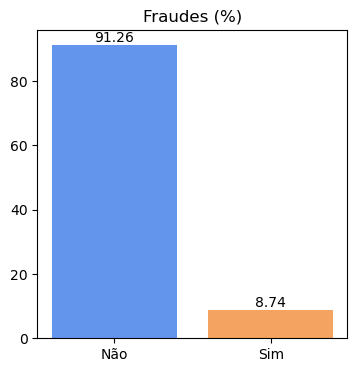

In [369]:
import matplotlib.pyplot as plt

contagem = (dados.fraud.value_counts(normalize=True) * 100).round(2)

azul = "cornflowerblue"
laranja = "sandybrown"
cores = [azul, laranja]

plt.figure(figsize=(4, 4))
bars = plt.bar(contagem.index.astype(str), contagem, color=cores)
plt.bar_label(bars)
plt.title("Fraudes (%)")
plt.gca().set_xticklabels(["Não", "Sim"]);

Existem muito mais casos de "não fraude" do que de fraude (era esperado), pois apenas cerca de 9% das transações são fraudulentas. Mas isso pode variar de acordo com o cenário, como por exemplo cenário de comprar online x compras presenciais, compras com chip x compras sem chip, etc. Veremos mais abaixo.

Mas de qualquer forma, temos que lidar com esse **desequilíbrio de classes** para treinarmos nosso algoritmo de machine learning. Mais abaixo usaremos a técnica SMOTE para fazer Oversampling, para assim treinarmos adequadamente nosso algoritmo para ficar preciso em identificar fraudes.

## Correlações

In [372]:
import plotly.express as px

corr = dados.corr().round(2)
mascara = np.tril(np.ones(corr.shape).astype(bool))
corr = corr.where(mascara)
fig = px.imshow(corr, text_auto=True)
fig.update_layout(width=1000, height=600)

- As **variáveis explicativas não possuem colinearidade** entre si, o que é bom (senão causaria instabilidade nos modelos de predição, principalmente os de regressão);
- Vemos uma certa **correlação positiva entre "fraud" e "ratio_to_median_purchase_price"**. Exploraremos mais abaixo.

## Variáveis contínuas

### Boxplot

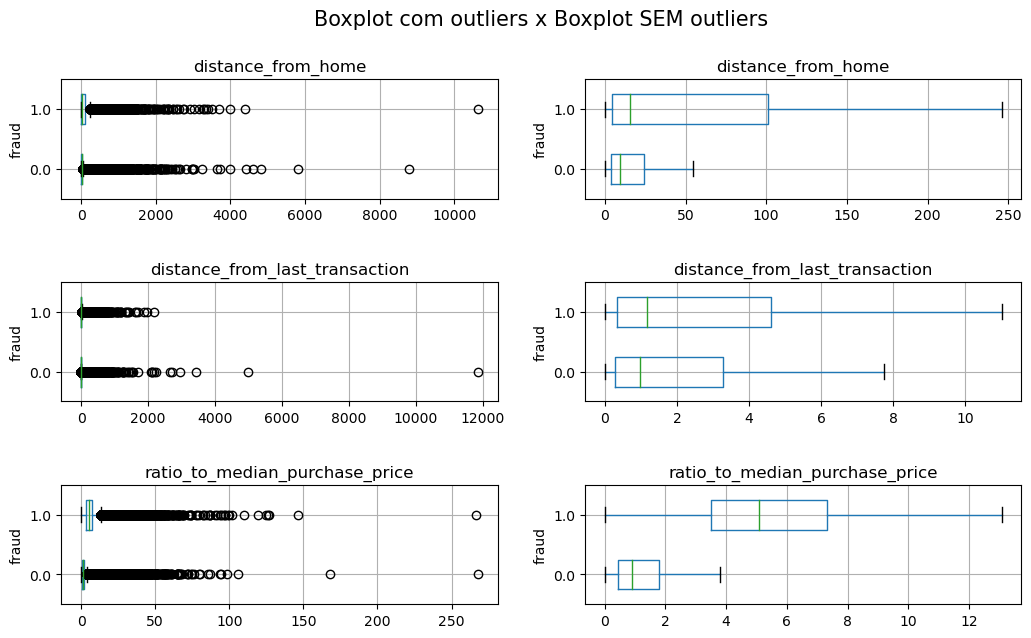

In [376]:
variaveis_continuas = [
    "distance_from_home",
    "distance_from_last_transaction",
    "ratio_to_median_purchase_price",
    ]

fig, axes = plt.subplots(3, 2, figsize=(12, 7))
fig.subplots_adjust(hspace=0.7)

dados.boxplot(variaveis_continuas, by="fraud", vert=False, widths=0.5,
              ax=axes[::, 0], sharex=False, sharey=False)

dados.boxplot(variaveis_continuas, by="fraud", vert=False, widths=0.5,
              ax=axes[::,1], sharex=False, sharey=False, showfliers=False);

fig.suptitle("Boxplot com outliers x Boxplot SEM outliers", size=15, y=1);

As variáveis acima alcançam **valores maiores em casos de fraude, principalmente a proporção ao preço médio de compra**, o que faz sentido já que normalmente fraudadores fazem compras de alto valor.
<br>Podemos concluir que:
- Se numa transação as variáveis acima possuem valores mais baixos, são baixas as chances de se tratar de uma fraude. Caso contrário, caso possuam valores muito altos, são altas as chances de fraude.

Abaixo uma análise descritiva, com média, mediana, quartis, etc:

### Estatísticas descritivas

In [379]:
dados.groupby("fraud")[variaveis_continuas].describe().round(2).T

fraud                                      0.0       1.0
distance_from_home             count 912,597.0  87,403.0
                               mean      22.83     66.26
                               std       52.83    134.39
                               min         0.0      0.03
                               25%        3.83      4.59
                               50%        9.67     15.45
                               75%       24.16    101.11
                               max    8,777.14 10,632.72
distance_from_last_transaction count 912,597.0  87,403.0
                               mean        4.3     12.71
                               std       22.47      48.0
                               min         0.0       0.0
                               25%        0.29      0.33
                               50%        0.99      1.16
                               75%        3.27       4.6
                               max    11,851.1   2,160.5
ratio_to_median_purchase_price count 912,597.0  87,403.0
                               mean       1.42      6.01
                               std        1.95      5.56
                               min         0.0      0.01
                               25%        0.45       3.5
                               50%        0.91      5.07
                               75%        1.79      7.33
                               max       267.8    266.69

As **médias** mostram o que vimos acima. Porém o problema de olhar só as médias é que elas costumam ser muito afetadas pelos outliers. Por isso a importância de olharmos também os **quartis** e os **boxplots**.

## Variáveis categóricas

### Comportamento das variáveis categóricas em cenários de Fraude x Não fraude

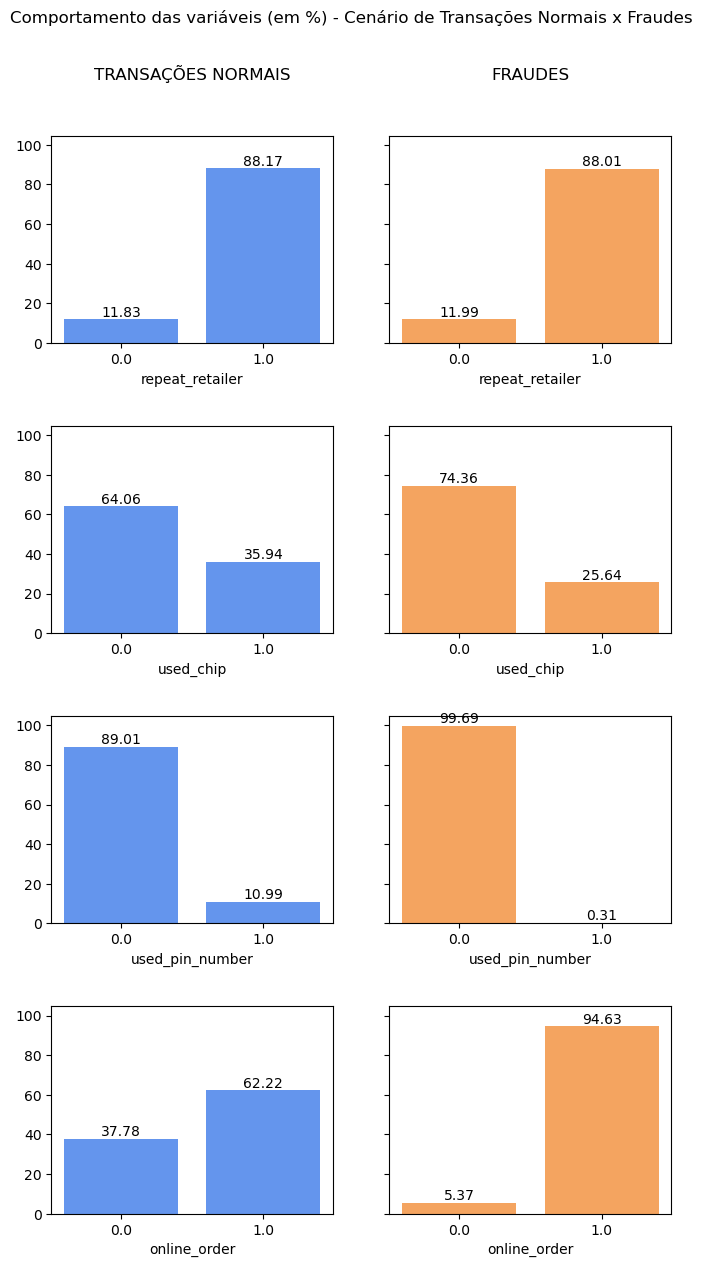

In [383]:
# # NO GOOGLE COLAB: AUMENTANDO A JANELA DE OUTPUT PARA NÃO PRECISAR
# # USAR A BARRA DE ROLAGEM
# from IPython.display import Javascript
# display(Javascript(
#     "google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})"))

variaveis_categoricas = [
    "repeat_retailer",
    "used_chip",
    "used_pin_number",
    "online_order",
    ]

fig, axes = plt.subplots(len(variaveis_categoricas), 2, figsize=(8, 14),
                         sharey=True)
fig.subplots_adjust(hspace=0.4)

for fraud, cor in zip([0, 1], cores):
    for i, variavel in enumerate(variaveis_categoricas):
        ax = axes[i][fraud]
        contagem = dados[dados.fraud == fraud][variavel].value_counts(
            normalize=True).sort_index()
        contagem = (contagem * 100).round(2)
        bars = ax.bar(contagem.index.astype(str), contagem, color=cor)
        ax.bar_label(bars)
        ax.set_xlabel(variavel)

fig.suptitle("Comportamento das variáveis (em %) - "
             "Cenário de Transações Normais x Fraudes", y=0.97)
axes[0][0].set_title("TRANSAÇÕES NORMAIS", y=1.23)
axes[0][1].set_title("FRAUDES", y=1.23);

Em comparação às transações normais, as fraudes:
- Quase nunca usam a senha do cartão (pin number): apenas 0,31%;
- São quase todas em compras online (aprox. 95%).

<br>Agora vejamos qual é o percentual de fraudes por variável:

### % de fraudes em cada cenário isolado

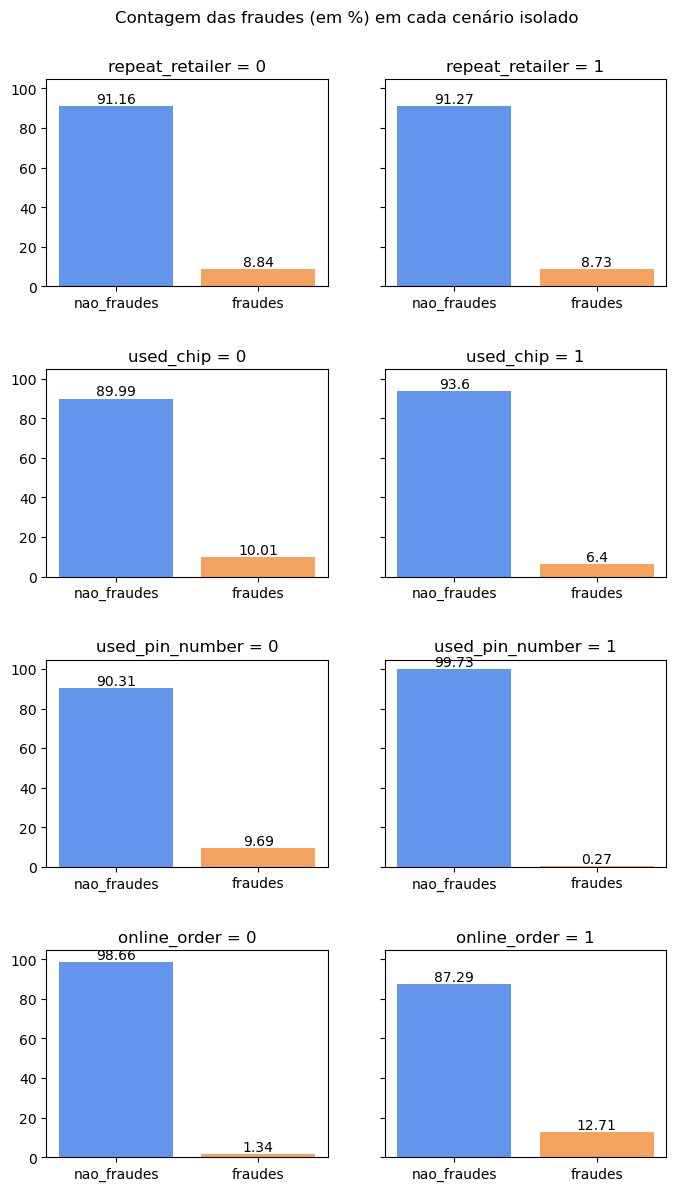

In [386]:
# # NO GOOGLE COLAB: AUMENTANDO A JANELA DE OUTPUT PARA NÃO PRECISAR
# # USAR A BARRA DE ROLAGEM
# display(Javascript(
#     "google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})"))

fig, axes = plt.subplots(len(variaveis_categoricas), 2, figsize=(8, 14),
                         sharey=True)
plt.subplots_adjust(hspace=0.4)

for i, variavel in enumerate(variaveis_categoricas):
    for b in [0, 1]:
        ax = axes[i][b]
        contagem = dados[dados[variavel] == b].fraud.replace(
            [0, 1], ["nao_fraudes", "fraudes"]).value_counts(
            normalize=True).sort_index(ascending=False)
        contagem = (contagem * 100).round(2)
        bars = ax.bar(contagem.index.astype(str), contagem, color=cores)
        ax.bar_label(bars)
        ax.set_title(f"{variavel} = {b}")

plt.suptitle("Contagem das fraudes (em %) em cada cenário isolado", y=0.93);

- Usar a **senha parece ser um ótimo fator de segurança**, pois das transações com senha, apenas 0,27% são fraudes, enquanto que das transações sem senha, 9,69% são fraudes, um aumento de 3.489%!!!
- Em seguida temos se a **compra foi online ou não**, onde o percentual de fraudes vai de 1,34% para 12,71%, um aumento de 849%!

<br>Segue a diferença de cada variável:

In [493]:
print("Percentual (%) de fraudes por variável (dif = diferença em %)")        
lista = [
    pd.crosstab(dados[variavel], dados.fraud, normalize="index")[1]
    for variavel in variaveis_categoricas
    ]
probabilidades = pd.concat(lista, axis=1)
probabilidades = (probabilidades * 100).round(2)
probabilidades.columns = variaveis_categoricas
probabilidades.loc["dif"] = probabilidades.apply(
    lambda x: max(x[0], x[1]) / min(x[0], x[1]) * 100 - 100).round(2)
probabilidades

Percentual (%) de fraudes por variável (dif = diferença em %)


,repeat_retailer,used_chip,used_pin_number,online_order
0.0,8.84,10.01,9.69,1.34
1.0,8.73,6.4,0.27,12.71
dif,1.26,56.41,"3,488.89",848.51


### % de fraudes em cada cenário combinado

In [495]:
print("===== Contagem de fraudes em cada cenário "
      "(combinação das variáveis) =====")
colunas_ordenadas = probabilidades.loc["dif"].sort_values(
    ascending=False).index
contagens = [
    dados[dados.fraud == i][colunas_ordenadas].value_counts(sort=False)
    for i in dados.fraud.unique()
    ]
cenarios = pd.concat(contagens, axis=1).fillna(0)
cenarios.columns = ["nao_fraudes", "fraudes"]
cenarios["percentual_fraudes"] = (
    cenarios.iloc[:, 1]
    / (cenarios.iloc[:, 0] + cenarios.iloc[:, 1])
    * 100
    ).round(2)
cenarios

===== Contagem de fraudes em cada cenário (combinação das variáveis) =====


nao_fraudes  fraudes  \
used_pin_number online_order used_chip repeat_retailer                         
0.0             0.0          0.0       0.0                    21543  2,451.0   
                                       1.0                   178700  1,430.0   
                             1.0       0.0                    13190     16.0   
                                       1.0                    96125    794.0   
                1.0          0.0       0.0                    39891  5,180.0   
                                       1.0                   279183 55,668.0   
                             1.0       0.0                    21417  2,817.0   
                                       1.0                   162213 18,774.0   
1.0             0.0          0.0       0.0                     2650      0.0   
                                       1.0                    20178      0.0   
                             1.0       0.0                     1465      0.0   
                                       1.0                    10905      1.0   
                1.0          0.0       0.0                     5024      8.0   
                                       1.0                    37439    256.0   
                             1.0       0.0                     2806      6.0   
                                       1.0                    19868      2.0   

                                                        percentual_fraudes  
used_pin_number online_order used_chip repeat_retailer                      
0.0             0.0          0.0       0.0                           10.22  
                                       1.0                            0.79  
                             1.0       0.0                            0.12  
                                       1.0                            0.82  
                1.0          0.0       0.0                           11.49  
                                       1.0                           16.62  
                             1.0       0.0                           11.62  
                                       1.0                           10.37  
1.0             0.0          0.0       0.0                             0.0  
                                       1.0                             0.0  
                             1.0       0.0                             0.0  
                                       1.0                            0.01  
                1.0          0.0       0.0                            0.16  
                                       1.0                            0.68  
                             1.0       0.0                            0.21  
                                       1.0                            0.01

De acordo com os cenários acima, vemos que:

Se uma transação tem:
- used_pin_number = 0
- online_order = 1
- used_chip = 0
- repeat_retailer = 1
- **= chance de ser fraude: 16,62%**

Se uma transação tem:
- used_pin_number = 1
- online_order = 0
- used_chip = 1
- repeat_retailer = 0
- **= chance de ser fraude: 0%**

Isso é só uma **análise superficial**, para termos ideia que quais variáveis categóricas representam mais chances da transação ser fraudulenta. Abaixo treinaremos nosso modelo de machine learning para nos dizer com precisão se uma transação é uma fraude ou não, considerando tanto essas variáveis categóricas como as contínuas.

# Treinando o modelo de machine learning

## Técnica holdout: Separação dos dados em treino e teste

In [394]:
from sklearn.model_selection import train_test_split
SEED = 7

X = dados.drop(columns="fraud")
y = dados.fraud
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, shuffle=True, random_state=SEED)

## Overfitting da classe minoritária (das fraudes)

Aumentando os exemplos de fraudes, igualando à quantidade de não-fraudes, para o modelo ficar bom em identificar fraudes

In [396]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=SEED)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

## Padronizando as variáveis explicativas

Para o modelo não ficar enviesado para a variável com escala mais alta (dependendo do modelo). Padronizaremos todas as variáveis explicativas com **StandardScaler**:

In [398]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

## LogisticRegression

Como queremos apenas saber se uma transação é ou não fraude (0 ou 1), começaremos usando um modelo de Regressão Logística:

In [400]:
from sklearn.linear_model import LogisticRegression

modelo_logistico = LogisticRegression(random_state=SEED)
modelo_logistico.fit(X_train_res_scaled, y_train_res)
y_pred = modelo_logistico.predict(X_test_scaled)

### Resultados

In [402]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96    182519
         1.0       0.58      0.95      0.72     17481

    accuracy                           0.94    200000
   macro avg       0.79      0.94      0.84    200000
weighted avg       0.96      0.94      0.94    200000



Refinando os resultados:

In [404]:
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time

def resultados(y_test, y_pred, matriz=False):
    print("===== RESULTADOS =====")
    print(f"Acurácia: {accuracy_score(y_test, y_pred):.2%}")
    print(f"Sensibilidade: {recall_score(y_test, y_pred):.2%}")
    print(f"Precisão: {precision_score(y_test, y_pred, zero_division=0):.2%}")
    print(f"F1 score: {f1_score(y_test, y_pred):.2%}")
    print(f"Curva ROC: {roc_auc_score(y_test, y_pred):.2%}")
    if matriz:
        print("\n===== MATRIZ DE CONFUSÃO =====")
        cm = confusion_matrix(y_test, y_pred)
        ConfusionMatrixDisplay(cm).plot()

def tempo_execucao(start_time):
    end_time = time.time()
    execution_time = end_time - start_time
    execution_time = pd.to_datetime(
        execution_time, unit="s").strftime("%Hh %Mm %Ss")
    print("===== TEMPO DE EXECUÇÃO =====")
    print(f"{execution_time}\n")

===== RESULTADOS =====
Acurácia: 93.51%
Sensibilidade: 95.11%
Precisão: 57.82%
F1 score: 71.92%
Curva ROC: 94.23%

===== MATRIZ DE CONFUSÃO =====


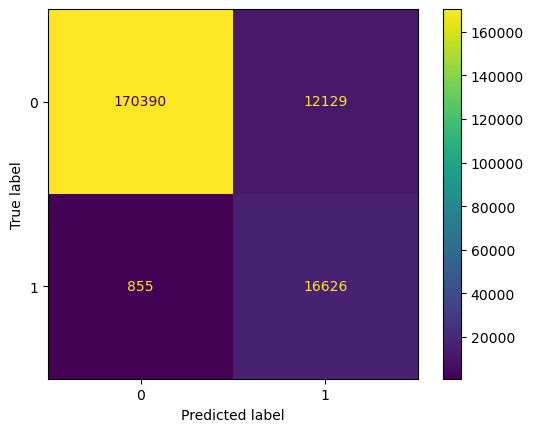

In [405]:
resultados(y_test, y_pred, matriz=True)

Olhar só a **Acurácia** (% acertos em geral) **não é o suficiente** pois queremos identificar o máximo de fraudes possíveis, mas também sem errar muito sobre as transações normais. Por isso estamos considerando também as seguintes medidas:
- **Sensibilidade (Revocação)**: A MAIS IMPORTANTE, é o % de fraudes detectadas;
- **Precisão**: % fraudes alegadas pelo modelo que realmente são fraudes;
- **F1 Score**: média harmônica entre Sensibilidade e Precisão;
- **Curva ROC**: basicamente é o quanto o modelo acerta as fraudes sem errar as não-fraudes.

A **Matriz de Confusão** é apenas uma análise visual das informações acima, como quantas fraudes são identificadas e quantas passam despercebidas (Sensibilidade), quantas fraudes declaradas realmente as são (Precisão), etc.

### Resultados sem o Overfitting

Se não tivéssemos feito o Overfitting, a Sensibilidade ficaria bem pior:

===== RESULTADOS =====
Acurácia: 95.89%
Sensibilidade: 60.31%
Precisão: 89.14%
F1 score: 71.94%
Curva ROC: 79.80%

===== MATRIZ DE CONFUSÃO =====


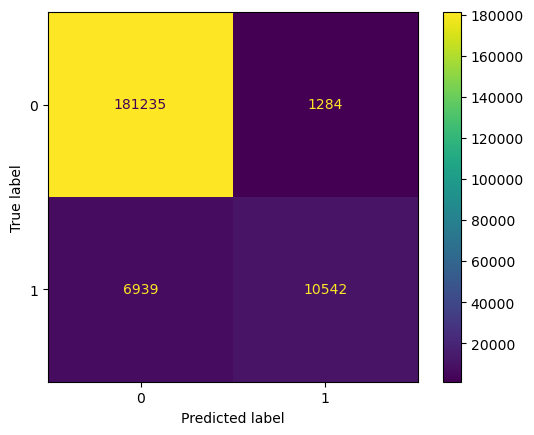

In [408]:
scaler2 = StandardScaler()
X_train_scaled2 = scaler2.fit_transform(X_train)
X_test_scaled2 = scaler2.transform(X_test)

modelo_sem_overfitting = LogisticRegression(random_state=SEED)
modelo_sem_overfitting.fit(X_train_scaled2, y_train)
y_pred_sem_overfitting = modelo_sem_overfitting.predict(X_test_scaled2)
resultados(y_test, y_pred_sem_overfitting, matriz=True)

## DummyClassifiers (baseline para comparação)

Modelos bobos, apenas para compararmos se nosso modelo não está muito melhor. Se os resultados forem semelhantes, isso é péssimo.

#### Prevendo tudo como 0 (não-fraude)

In [411]:
from sklearn.dummy import DummyClassifier

# A estratégia "prior" é a padrão
# (nesse caso, vai prever tudo como 0 - não-fraude)
dummy_prior = DummyClassifier()
dummy_prior.fit(X_train_res_scaled, y_train_res)
y_pred = dummy_prior.predict(X_test_scaled)
resultados(y_test, y_pred)

===== RESULTADOS =====
Acurácia: 91.26%
Sensibilidade: 0.00%
Precisão: 0.00%
F1 score: 0.00%
Curva ROC: 50.00%


A Acurácia não parece tão ruim, porém a Sensibilidade ficou em 0%. Ou seja, todas as fraudes passaram despercebidas! Por isso a importância de olharmos as outras métricas.

#### Prevendo tudo como 1 (fraude)

In [414]:
dummy_constant = DummyClassifier(strategy="constant", constant=1)
dummy_constant.fit(X_train_res_scaled, y_train_res)
y_pred = dummy_constant.predict(X_test_scaled)
resultados(y_test, y_pred)

===== RESULTADOS =====
Acurácia: 8.74%
Sensibilidade: 100.00%
Precisão: 8.74%
F1 score: 16.08%
Curva ROC: 50.00%


Aqui a Sensibilidade ficou em 100%, ou seja, identificou todas as fraudes! Parece ótimo, mas a precisão ficou horrível, já que esse dummy errou o diagnóstico de todas as não-fraudes dizendo que são todas fraudes. Isso é péssimo.

#### Prevendo de forma estratificada (mesma proporção de fraudes vista no treino)

In [417]:
dummy_stratified = DummyClassifier(strategy="stratified", random_state=SEED)
dummy_stratified.fit(X_train_res_scaled, y_train_res)
y_pred = dummy_stratified.predict(X_test_scaled)
resultados(y_test, y_pred)

===== RESULTADOS =====
Acurácia: 50.09%
Sensibilidade: 49.99%
Precisão: 8.76%
F1 score: 14.90%
Curva ROC: 50.05%


Esse se saiu menos pior. Nosso modelo de Regressão Logística está muito melhor. Segue novamente:

===== RESULTADOS =====
Acurácia: 93.51%
Sensibilidade: 95.11%
Precisão: 57.82%
F1 score: 71.92%
Curva ROC: 94.23%

===== MATRIZ DE CONFUSÃO =====


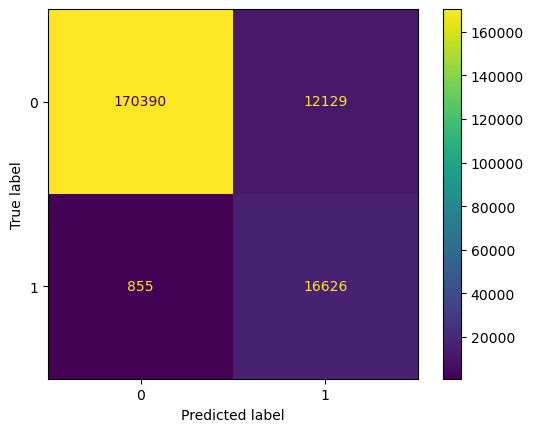

In [419]:
y_pred = modelo_logistico.predict(X_test_scaled)
resultados(y_test, y_pred, matriz=True)

Vejamos se conseguimos melhores resultados com outros modelos:

## DecisionTree

===== TEMPO DE EXECUÇÃO =====
00h 00m 06s

===== RESULTADOS =====
Acurácia: 99.38%
Sensibilidade: 99.35%
Precisão: 93.92%
F1 score: 96.56%
Curva ROC: 99.37%

===== MATRIZ DE CONFUSÃO =====


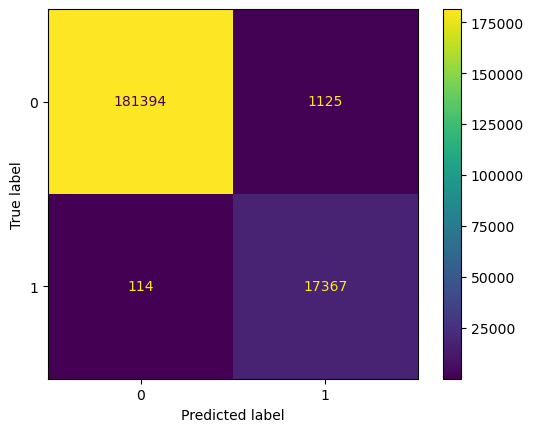

In [422]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=4, random_state=SEED)

start_time = time.time()
tree.fit(X_train_res_scaled, y_train_res)
y_pred = tree.predict(X_test_scaled)
tempo_execucao(start_time)

resultados(y_test, y_pred, matriz=True)

A árvore de decisão se saiu muito melhor, entregando quase **87% menos falsos negativos**! (fraudes não detectadas caíram de 855 para 114 (-741))

### Visualizando a árvore

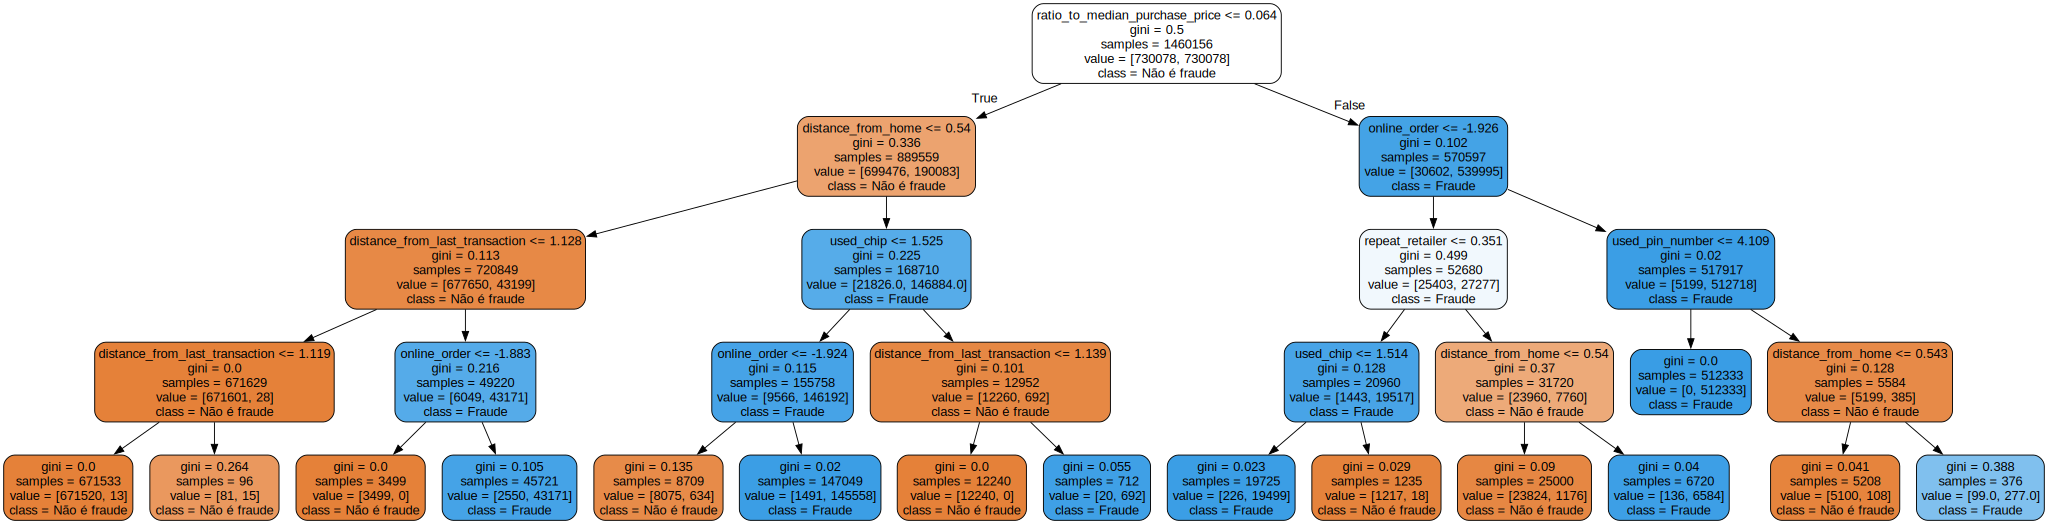

In [425]:
from sklearn.tree import export_graphviz
import graphviz

dot = export_graphviz(
    tree, feature_names=X.columns, class_names=["Não é fraude", "Fraude"],
    filled=True, rounded=True)
graphviz.Source(dot)

A árvore ficou grande, é assim mesmo. Mas caso fosse necessário **diminui-la**, poderíamos mexer na:
- profundidade (**max_depth**);
- quantidade mínima de amostras para criar uma folha (**min_samples_leaf**)
- quantidade mínima de amostras para dividir um nó (**min_samples_split**)

Porém, deve-se mexer com cuidado para não perder eficiência.

<br>Vejamos se conseguimos um modelo ainda melhor:

## RandomForest

"Floresta de árvores", usa várias DecisionTrees (por padrão 100) para chegar a um resultado final.

Esse modelo costuma ser mais robusto, **mais preciso** e evita o overfitting, porém é bem **mais lento**.

===== TEMPO DE EXECUÇÃO =====
00h 00m 49s

===== RESULTADOS =====
Acurácia: 99.85%
Sensibilidade: 99.81%
Precisão: 98.55%
F1 score: 99.17%
Curva ROC: 99.83%

===== MATRIZ DE CONFUSÃO =====


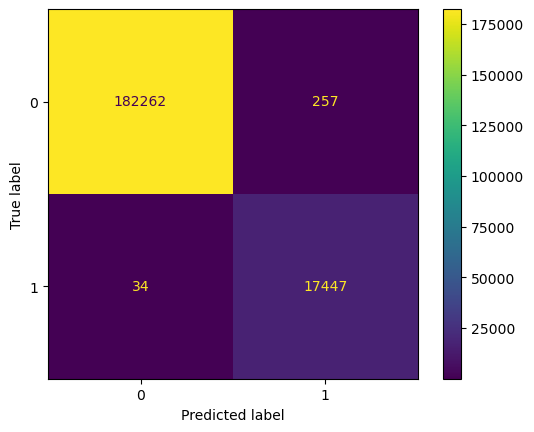

In [429]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=4, random_state=SEED, n_jobs=-1)
# n_jobs=-1 para paralelizar e agilizar o processo, usando todos os
# núcleos disponíveis. Usar com cautela.

start_time = time.time()
rf.fit(X_train_res_scaled, y_train_res)
y_pred = rf.predict(X_test_scaled)
tempo_execucao(start_time)

resultados(y_test, y_pred, matriz=True)

Apesar da lentidão, conseguiu se sair ainda melhor, entregando **70% menos falsos negativos** que a DecisionTree (fraudes não detectadas caíram de 114 para 34 (-80)).

Vejamos se conseguimos resultados ainda melhores refinando os hiperparâmetros:

## RandomSearchCV

- Ajuda a encontrar os **melhores hiperparâmetros** para otimizar o modelo;
- Porém, normalmente **demora muito**, ainda mais quando há muitos hiperparâmetros para testar. Por isso é necessário escolhermos o número de iterações/combinações de hiperparâmetros para testar aleatoriamente;
- Por padrão é feita uma **Validação Cruzada** de 5-folds, que divide os dados em treino/teste de 5 formas diferentes, testando cada cenário (dobra). Assim evita o enviesamento de uma única divisão ruim que ocasionalmente possamos fazer no holdout;
- Usaremos **Pipeline** para que o Overfitting e a Padronização com StandardScaler sejam aplicados somente nos dados de teste de cada cenário (dobra) da validação cruzada.

Observações:
- É uma versão do GridSearchCV, que testa todos os hiperparâmetros fornecidos, porém demora muito mais;
- O ideal seria testarmos todas as combinações de hiperparâmetros para otimizarmos nosso modelo ao máximo. Porém, isso vai depender do custo computacional e se há tempo disponível para aguardar o processamento;

In [568]:
from sklearn.model_selection import RandomizedSearchCV
from imblearn.pipeline import Pipeline
# Pipeline da imblearn permite inserir o SMOTE, diferente da sklearn

pipeline = Pipeline([
    ("smote", SMOTE(random_state=SEED)),
    ("scaler", StandardScaler()),
    ("modelo", RandomForestClassifier(random_state=SEED, n_jobs=-1)),
    ])
parametros = {
    "modelo__criterion": ["gini", "entropy", "log_loss"],
    "modelo__max_depth": range(4, 11),
    "modelo__bootstrap": [True, False],
    }
scoring = ["recall", "precision", "f1"]
search = RandomizedSearchCV(
    pipeline,
    parametros,
    scoring=scoring,
    cv=3,  # 3 em vez de 5 para ser mais rápido
    n_iter=20,
    refit="f1",
    n_jobs=-1,
    random_state=SEED,
    )

ctypes.windll.kernel32.SetThreadExecutionState(0x80000001)
# Para o sistema não hibernar
start_time = time.time()
search.fit(X, y);
tempo_execucao(start_time)
ctypes.windll.kernel32.SetThreadExecutionState(0x80000000);
# Voltando a configuração padrão de hibernação

===== TEMPO DE EXECUÇÃO =====
01h 13m 18s



Salvar para não perdermos esse processamento de horas:

In [693]:
import joblib

joblib.dump(search, "search.pkl")

['search.pkl']

In [691]:
pd.DataFrame(search.cv_results_).round(6).sort_values(
    ["rank_test_f1", "rank_test_recall", "rank_test_precision"]
    )[[
        "mean_test_recall",
        "mean_test_precision",
        "mean_test_f1",
        "rank_test_recall",
        "rank_test_precision",
        "rank_test_f1",
        "param_modelo__criterion",
        "param_modelo__max_depth",
        "param_modelo__bootstrap",
    ]].reset_index(drop=True)

,mean_test_recall,mean_test_precision,mean_test_f1,rank_test_recall,rank_test_precision,rank_test_f1,param_modelo__criterion,param_modelo__max_depth,param_modelo__bootstrap
0,0.999886,1.0,0.999943,1,1,1,entropy,10,False
1,0.999886,1.0,0.999943,2,1,2,entropy,10,True
2,0.999886,1.0,0.999943,2,1,2,log_loss,10,True
3,0.999863,1.0,0.999931,4,1,4,log_loss,8,False
4,0.999863,1.0,0.999931,4,1,4,entropy,8,False
5,0.999863,1.0,0.999931,6,1,6,log_loss,7,True
6,0.999863,1.0,0.999931,7,1,7,log_loss,8,True
7,0.999851,1.0,0.999926,8,1,8,entropy,7,False
8,0.999851,1.0,0.999926,8,1,8,log_loss,7,False
9,0.999851,1.0,0.999926,10,1,10,gini,9,True


Olhando a coluna mean_test_f1, há uma **diferença muito pequena** entre os 11 primeiros modelos (da linha 0 a 10), nos quais o hiperparâmetro max_depth é maior ou igual a 7, fazendo os modelos terem desempenhos quase iguais entre si.

A princípio, poderíamos usar o modelo mais simples deles, com os hiperparâmetros menos complexos. Porém, como estamos tratando de fraude bancária, **é muito importante identificarmos o máximo de fraudes possíveis**. Cada fraude não identificada é um cliente sendo roubado e uma grande dor de cabeça para a instituição, que pode ser processada, sair noticiário na TV e perder reputação.

Então, por exemplo, apesar da sensibilidade (mean_test_recall) das linhas 2 e 3 parecerem iguais (99,9886% e 99,9863%, diferença de apenas 0,0023%), se considerarmos um cenário de 100 milhões de transações por dia, é uma diferença de **2.300 fraudes não identificadas por dia**. Só para termos um comparativo, as transações Pix no Brasil chegaram a bater recorde de 224 milhões de transações por dia em 2024 (fonte: [Agência Brasil](https://agenciabrasil.ebc.com.br/economia/noticia/2024-07/pix-bate-recorde-e-supera-224-milhoes-de-transacoes-em-um-dia)).

Logo, é importante sempre contextualizarmos esses números percentuais para o cenário do negócio que estamos trabalhando, para o impacto crítico que podem causar.

### Hiperparâmetros do melhor modelo

In [110]:
import joblib

search = joblib.load("search.pkl")

In [571]:
search.best_params_

{'modelo__max_depth': 10,
 'modelo__criterion': 'entropy',
 'modelo__bootstrap': False}

Encontrado o melhor modelo, faremos a **Validação Cruzada Aninhada** para obtermos resultados mais realistas, não tão otimistas:

In [673]:
from sklearn.model_selection import cross_validate
import ctypes

ctypes.windll.kernel32.SetThreadExecutionState(0x80000001)
start_time = time.time()
final_scores = cross_validate(search, X, y, cv=3, scoring=scoring, n_jobs=-1)
tempo_execucao(start_time)
ctypes.windll.kernel32.SetThreadExecutionState(0x80000000);

===== TEMPO DE EXECUÇÃO =====
02h 16m 17s



In [695]:
final_scores = pd.DataFrame(final_scores)
final_scores

,fit_time,score_time,test_recall,test_precision,test_f1
0,"8,161.063084602356",1.4099433422088623,0.9998627080830617,1.0,0.9999313493289397
1,"8,150.825265169144",3.7842421531677246,0.9999313516853161,1.0,0.9999656746644698
2,"8,141.485084295273",6.3436994552612305,0.9998627033706322,1.0,0.9999313469724015


In [697]:
import joblib

joblib.dump(final_scores, "final_scores.pkl")

['final_scores.pkl']

In [699]:
import numpy as np
import scipy.stats as stats

def print_media_e_intervalo(scores):
    media = scores.mean()
    desvio = scores.std()
    
    n = len(scores)
    erro_padrao = desvio / np.sqrt(n)
    t_value = stats.t.ppf(1-0.05/2, df=n-1)  # df = graus de liberdade
    margem = t_value * erro_padrao
    min_conf = max(media - margem, 0)
    max_conf = min(media + margem, 1)
    
    print(f"Média: {media:.4%}")
    print(f"Intervalo de confiança: [{min_conf:.4%}, {max_conf:.4%}]")


print("===== SCORES DO MELHOR MODELO =====")
print("RECALL")
print_media_e_intervalo(final_scores.test_recall)
print("\nPRECISION")
print_media_e_intervalo(final_scores.test_precision)
print("\nF1")
print_media_e_intervalo(final_scores.test_f1)

===== SCORES DO MELHOR MODELO =====
RECALL
Média: 99.9886%
Intervalo de confiança: [99.9787%, 99.9984%]

PRECISION
Média: 100.0000%
Intervalo de confiança: [100.0000%, 100.0000%]

F1
Média: 99.9943%
Intervalo de confiança: [99.9894%, 99.9992%]


# Finalizando e salvando o modelo

Com o modelo final determinado, vamos treiná-lo com TODOS os dados e salvá-lo para reutilização ou implantação posterior

In [701]:
import joblib

sm = SMOTE(random_state=SEED)
X_res, y_res = sm.fit_resample(X, y)

scaler = StandardScaler()
scaler.fit(X_res)
X_res_scaled = scaler.transform(X_res)

best_params = {
    k.replace("modelo__", ""): v for k, v in search.best_params_.items()
    }
modelo = RandomForestClassifier(random_state=SEED, n_jobs=-1, **best_params)
modelo.fit(X_res_scaled, y_res)
modelo_e_scaler = (modelo, scaler)
joblib.dump(modelo_e_scaler, 'modelo_e_scaler.pkl')

['modelo_e_scaler.pkl']

O modelo salvo pode ser carregado mais tarde para fazer previsões em novos dados, sem a necessidade de treiná-lo novamente. Esse seria o código:

In [703]:
import joblib

modelo, scaler = joblib.load('modelo_e_scaler.pkl')

X_novos_dados = X  # Novos dados recebidos
X_novos_dados_scaled = scaler.transform(X_novos_dados)
y_pred = modelo.predict(X_novos_dados_scaled)
y_pred

array([0., 0., 0., ..., 0., 0., 0.])

# Conclusões

- A **ratio_to_median_purchase_price** é a variável mais importante para estimar se uma transação é ou não uma fraude;
- Quase todas as fraudes (95%) são em **compras online**;
- **used_pin_number** é a característica que quase consegue zerar o percentual de fraudes (cai de 9,69% para 0,27%);
- O melhor modelo de predição foi o **RandomForestClassifier**, com score F1 de 99.9943%, cobrindo cerca de **99.9886%** das fraudes (sensibilidade) e precisão de 100%.